# Lecture 12 - Community Detection

In this notebook we will learn how to find communities in networks.


Our example network will be a Twitter follower network.

Below is the overview of this notebook.


<ol type = 1>
    <li> Data processing</li>
        <ol type = a>
            <li> Load follower network</li>
        </ol>
    <li> Find Communities</li>
        <ol type = a>
            <li> Modularity communities</li>
            <li> Spectral clustering communities</li>
        </ol>

   <li> Community Analysis </li>
        <ol type = a>
            <li> Draw network with nodes colored by community membership</li>
            <li> Find top centrality users inside communities</li>
    <li>Draw each community sub-network with nodes sized by centrality</li>
       </ol>
</ol>

This notebook can be opened in Colab 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/Lecture12_CommunityDetection.ipynb)

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.




# Clones, installs, and imports


## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [ ]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

## Install Requirements 


In [ ]:
!pip install -r requirements.txt


## Import Packages



In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scripts.communities import spectral_communities


## Load network into a networkx object

The follower network is saved in a pickle file as a networkx object.


In [2]:
#filename of follower network
target_user = "JoeBiden"
fname_following = f"data/friends_network_{target_user}.pickle"

G = nx.read_gpickle(fname_following)
G.remove_node(target_user)

nv = G.number_of_nodes()
ne = G.number_of_edges()
print(f"Network has {nv} nodes and {ne} edges")

Network has 26 nodes and 113 edges


# Find Communities

## Find modularity communities

We will use the `modularity` function in networkx to find the modularity communities.  `modularity` returns a list of lists for the communities.  We will turn that into a nice dataframe called `df_mod` for the modularity communities.  To get the number of communities, which we call `ncomm_mod`, we can use the `unique` function on the `"community"` column of the `df_mod` dataframe.

In [3]:
Comm = nx_comm.greedy_modularity_communities(G.to_undirected())
C = []
V = []
for count,comm in enumerate(Comm):
    for v in comm:
        C.append(count)
        V.append(v)
        
df_mod = pd.DataFrame({'screen_name':V, 'community':C})
df_mod.head()

ncomm_mod = len(df_mod.community.unique())
print(f"{ncomm_mod} modularity communities")

3 modularity communities


## Find spectral communities

We will use the `spectral_clustering` function to find the spectral communities.  We have to select the number of communities, which we call `k`.  We will obtain a dataframe `df_spec` that has the community membership of each node.




In [4]:
k = 4
df_spec = spectral_communities(G,k)

ncomm_spec = len(df_spec.community.unique())
print(f"{ncomm_spec} spectral communities")

4 spectral communities


# Community Analysis

## Plot the community sizes

We can then plot the community sizes using `countplot`.

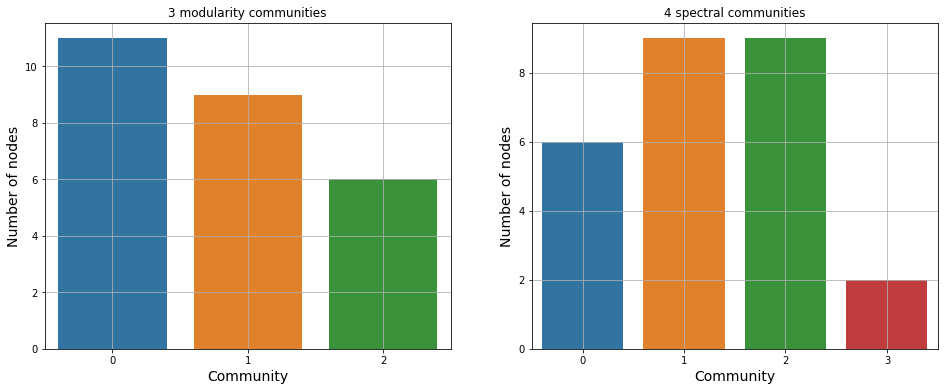

In [11]:
#plot modularity community sizes
fig = plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
ax = sns.countplot(data=df_mod, x="community")
plt.xlabel("Community", fontsize = 14)
plt.ylabel("Number of nodes", fontsize = 14)
plt.title(f"{ncomm_mod} modularity communities")
plt.grid()


#plot spectral community sizes
plt.subplot(1,2,2)
ax = sns.countplot(data=df_spec, x="community")
plt.xlabel("Community", fontsize = 14)
plt.ylabel("Number of nodes", fontsize = 14)
plt.title(f"{ncomm_spec} spectral communities")
plt.grid()
plt.show()



## Print community sizes

 We can print out  the size of each community using the `groupby` and `count` functions.  `groupby` will create a grouped dataframe, grouped by the value of specified columns.  `count` will produce a dataframe where each row is a group and the value is the count of the number of elements in the group. 

In [14]:
df_mod.groupby(by='community',as_index=False).count()

,community,screen_name
0,0,11
1,1,9
2,2,6


In [15]:
df_spec.groupby(by='community',as_index=False).count()

,community,screen_name
0,0,6
1,1,9
2,2,9
3,3,2


### Statistics of community sizes

We will make a dataframe called `df_mod_size` that has as columns `"community"` and `"size"`.  We do this with the `groupy` and `count` functions, followed by the `rename` function (to change the column name to `"size"`).  Then we can look at statistics of the community size using several functions applied  to the the `size` column.  The functions we can use are

1. `min` - minimum of the column
2. `max` - maximum of column
3. `mean` - mean of column

You can find many more descriptive statistics functions here: https://www.tutorialspoint.com/python_pandas/python_pandas_descriptive_statistics.htm

In [27]:
df_mod_size = df_mod.groupby(by='community',as_index=False).count()
df_mod_size = df_mod_size.rename(columns={"screen_name":'size'})
size_min = df_mod_size["size"].min()
size_max =  df_mod_size["size"].max()
size_mean =  df_mod_size["size"].mean()

print(f"Minimum community size = {size_min:.3f} nodes")
print(f"Maximum community size = {size_max:.3f} nodes")
print(f"Mean community size = {size_mean:.3f} nodes")

Minimum community size = 6.000 nodes
Maximum community size = 11.000 nodes
Mean community size = 8.667 nodes


## Network Visualization

We will draw the network and color the nodes by their community membership.  

### Create color list

Create a list of random colors called `Colors`.  Each color is stored at a 3-dimensional array in the [red,green,blue] format (also known as Roy G. Biv).

In [36]:
Colors = [np.random.uniform(0,1,3) for _ in range(100)]


### Create node color lists

Next we create lists of the node colors.  We do this using the fancy list comprehension trick.  We get the community index of a node from community dataframe (either `df_mod` or `df_spec`), and then we get the color corresponding to this index in `Colors`.

In [32]:
node_color_mod = [Colors[df_mod.community[df_mod.screen_name==node].values[0]] for node in G.nodes()]
node_color_spec = [Colors[df_spec.community[df_spec.screen_name==node].values[0]] for node in G.nodes()]

### Draw network, nodes colored by modularity community

In [38]:
pos = nx.kamada_kawai_layout(G)  #position of each node in the network

edge_color = 'purple'
background_color = 'black'
edge_width = .5
node_size = 300

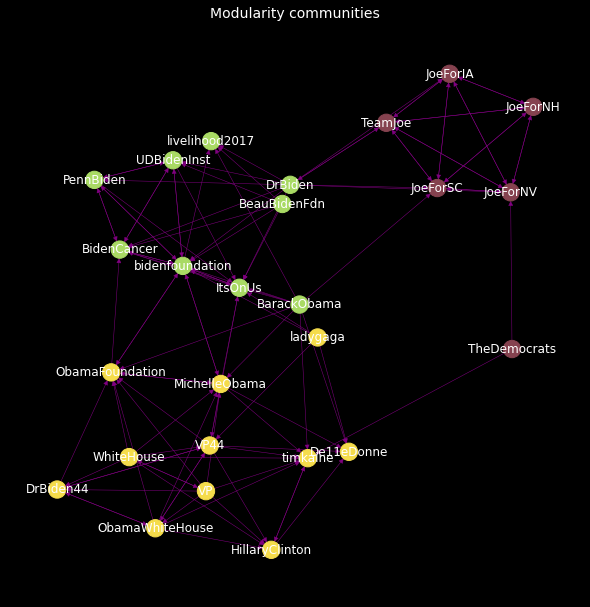

In [39]:
#Draw the network, with labels    
fig = plt.figure(figsize=(8,8))
nx.draw(G, pos, node_color = node_color_mod, 
        width= edge_width, 
        edge_color=edge_color,
        node_size=node_size,
       with_labels=True,
        font_color = 'white')
fig.set_facecolor(background_color)
plt.title("Modularity communities",color = 'white',fontsize = 14)
plt.show()




### Draw network, nodes colored by spectral clustering community

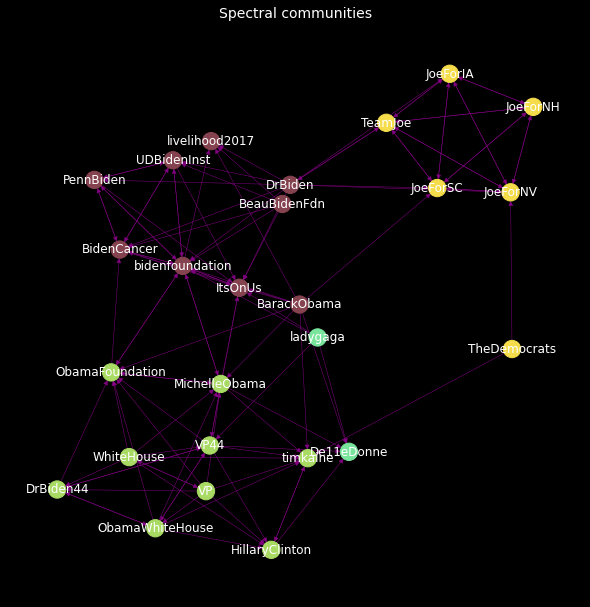

In [40]:
fig = plt.figure(figsize=(8,8))
nx.draw(G, pos, node_color = node_color_spec, 
        width= edge_width,
        edge_color=edge_color,
        node_size=node_size,
       with_labels=True,
        font_color = 'white')
fig.set_facecolor(background_color)
plt.title("Spectral communities",color = 'white',fontsize = 14)
plt.show()

## Finding leaders in each community using network centralities

Now that we have segmented the nodes into communities, we need to understand what the communities tell us.  One way to do this is to look at the high centrality users in each community.  We can calculate the network centrality of all the nodes, then in each community print out the top users.

### Calculate centralities

First we calculate the centralities of each node.

In [41]:
G = G.to_directed()  #make sure G is a directed network
Din = nx.in_degree_centrality(G)
Dout = nx.out_degree_centrality(G)
CC = nx.closeness_centrality(G.reverse())  #reverse edges to match networx convention
BC = nx.betweenness_centrality(G)
EC = nx.eigenvector_centrality(G.reverse(),max_iter = 1000)  #reverse edges to match networx convention

dictionary_list = []
for screen_name in Din.keys():
    row = {'screen_name':screen_name,
          'in_degree_centrality':Din[screen_name],
          'out_degree_centrality':Dout[screen_name],
          'closeness_centrality':CC[screen_name],
          'betweenness_centrality':BC[screen_name],
          'eigenvector_centrality':EC[screen_name]}
    dictionary_list.append(row)
df_centrality = pd.DataFrame(dictionary_list)



### Merge centrality and spectral community dataframe

We will make one big dataframe `df` that contains the centrality and spectral community information for the nodes.  We do this using the `merge` function on `df_spec` and `df_centrality`.

In [42]:
#merge df_spec with df_centrality into one super dataframe
df = df_mod.merge(df_centrality, left_on='screen_name', right_on='screen_name')
df.head()

,screen_name,community,in_degree_centrality,out_degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality
0,ObamaWhiteHouse,0,0.12,0.24,0.293913,0.003111,1.541135e-05
1,HillaryClinton,0,0.20,0.08,0.080000,0.005278,6.880797e-56
2,WhiteHouse,0,0.04,0.28,0.346154,0.000556,2.085629e-05
3,MichelleObama,0,0.28,0.20,0.293913,0.048778,1.456783e-05
4,timkaine,0,0.32,0.04,0.053333,0.009167,6.880797e-56


### Show top centrality nodes in each community

We choose a centrality with the variable `centrality`.  We iterate over each community index (with the `unique` function), pull out the nodes from the community, and look at the top `display_max` scoring nodes.

In [44]:
display_max = 5
centrality = 'closeness_centrality'

print(f"Spectral communities: top {display_max} {centrality}")
for community_index in df["community"].unique():
    df_comm = df[df["community"]==community_index]
    leaders = df_comm.sort_values(by= [centrality], ascending = False).screen_name[0:display_max].tolist()
    print(f"Community {community_index}: leaders = {leaders}")

Spectral communities: top 5 closeness_centrality
Community 0: leaders = ['WhiteHouse', 'VP', 'ladygaga', 'VP44', 'ObamaWhiteHouse']
Community 1: leaders = ['BarackObama', 'DrBiden', 'bidenfoundation', 'ItsOnUs', 'BeauBidenFdn']
Community 2: leaders = ['TeamJoe', 'JoeForNV', 'JoeForSC', 'JoeForNH', 'JoeForIA']


#### Use top centrality users to describe each community

Community 0 is ....

Community 1 is ...

Community 2 is ...

## Find best spectral communities using modularity

We will go through different values of `k` using a `for` loop and calculate the spectral communities.  We will calculate the modularity of these communities.  This requires us to convert the communities in the dataframe `df_community` into a list of lists we call `C`.  Each list in `C` has the members of the community.  As we go through the values of `k` we will keep track of the value that gives the highest modularity.  We call this value `kmax` and the corresponding modularity is `qmax`.

In [46]:
K = np.arange(1,10,1)
Mod = []
kbest = 0
mod_best = -1e10
for k in K:
    df_community = spectral_communities(G,k)  #find spectral communities
    #create list of lists of community members
    C = []
    for community_index in df_community.community.unique():
        community = df_community.screen_name[df_community.community==community_index].tolist()
        C.append(community)
    mod = nx_comm.modularity(G, C)  #calculate modularity of communities
    Mod.append(mod)
 
    print(f"k={k}, modularity = {mod:.3f}")

    #keep track of the best modularity and corresponding k
    if mod>mod_best:
        mod_best = mod
        kbest = k

print(f"\nbest k = {kbest}, modularity = {mod_best:.2f}")

k=1, modularity = 0.000
k=2, modularity = 0.311
k=3, modularity = 0.472
k=4, modularity = 0.463
k=5, modularity = 0.459
k=6, modularity = 0.395
k=7, modularity = 0.344
k=8, modularity = 0.336
k=9, modularity = 0.268

best k = 3, modularity = 0.47


### Plot k versus modularity

We plot `Mod` versus `K`.  We want to use seaborn for the plot, so we make a dataframe `df_k_mod` that has as columns `"k"` and `"modularity"`.  We make the plot using `lineplot`.    We also put a nice marker at the location `(kbest,mod_best)`. We can choose the marker.  Here is a list of markers in Matplotlib:  https://matplotlib.org/3.3.3/api/markers_api.html

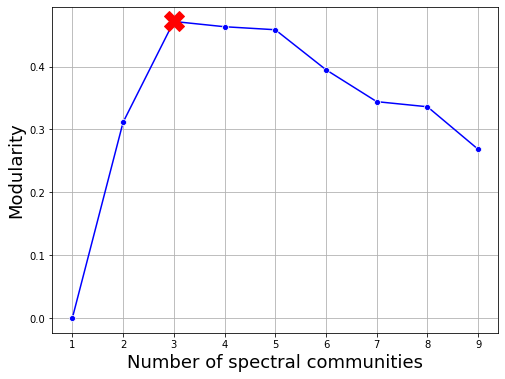

In [50]:
df_k_mod = pd.DataFrame({'k':K,'modularity':Mod})

fig = plt.figure(figsize = (8,6))
sns.lineplot(data = df_k_mod, x = 'k',y = 'modularity',marker = 'o',color = 'blue')
plt.plot(kbest,mod_best,marker = 'X',color = 'red',markersize = 20)

plt.xlabel("Number of spectral communities",fontsize = 18)
plt.ylabel("Modularity",fontsize = 18)
plt.grid()
plt.show()

### Draw network with best spectral communities

Now we recalculate the spectral communities, using `k = kbest` and draw the network with nodes colored by community.

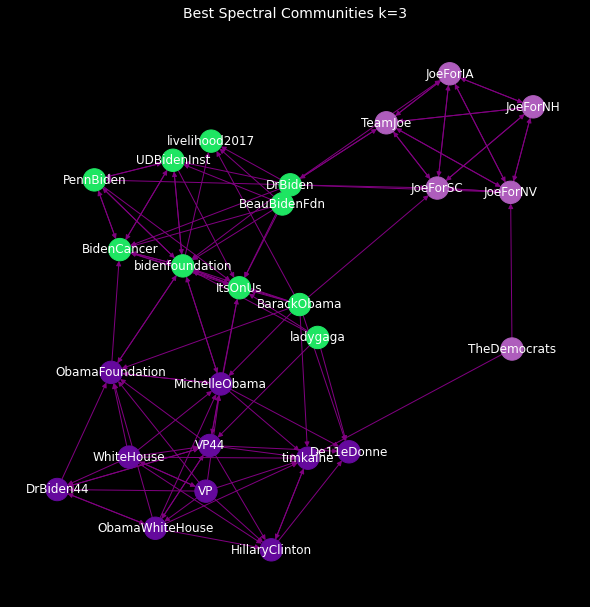

In [51]:
df_spec_best = spectral_communities(G,kbest)
Colors = [np.random.uniform(0,1,3) for _ in range(100)]
node_color = [Colors[df_spec_best.community[df_spec_best.screen_name==node].values[0]] for node in G.nodes()]

edge_color = 'purple'
background_color = 'black'
edge_width = 1
node_size = 500

   
#Draw the network, with labels    
fig = plt.figure(figsize=(8,8))
nx.draw(G, pos, node_color = node_color, width= edge_width,edge_color=edge_color,node_size=node_size,
       with_labels=True,font_color = 'white')
fig.set_facecolor(background_color)
plt.title(f"Best Spectral Communities k={kbest}",color = 'white',fontsize = 14)
plt.show()

## Draw each community

Use a `for` loop to draw each community individually.  We use the `subgraph` command to draw just the community and not the entire network.

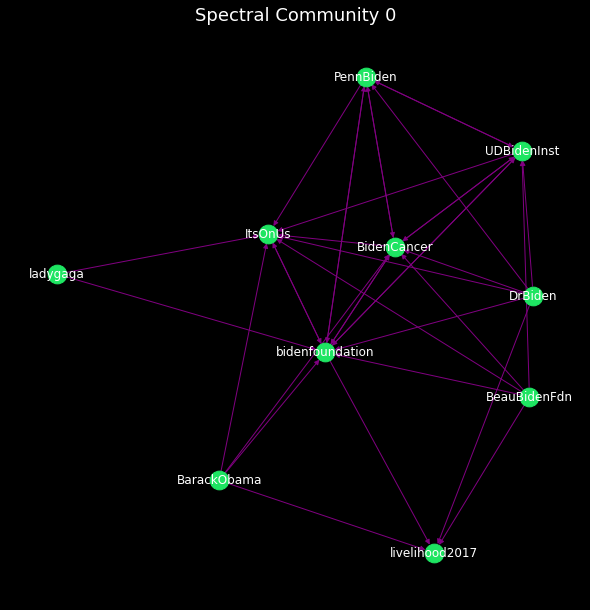

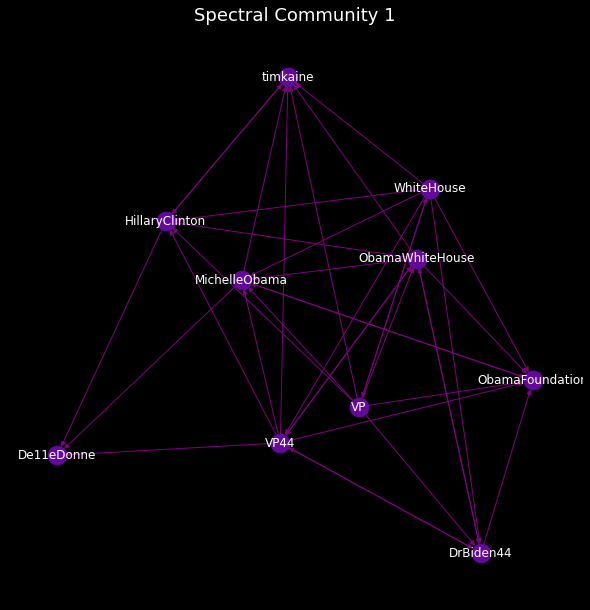

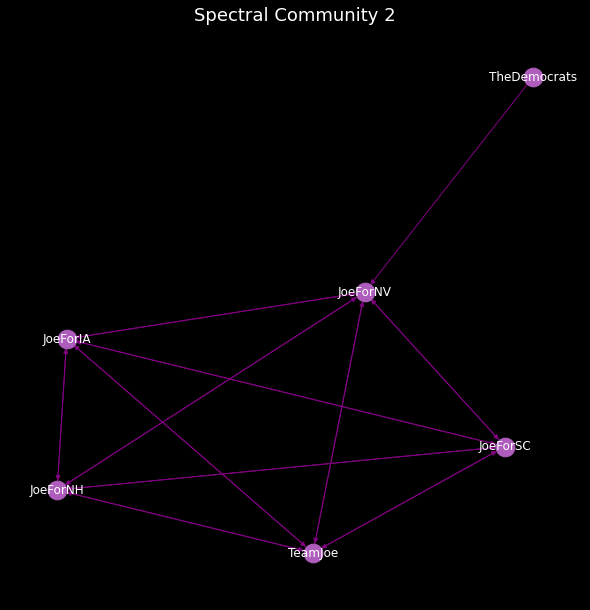

In [70]:

for community_index in np.sort(df_spec_best.community.unique()):
    nodes = df_spec_best.loc[df_spec_best["community"]==community_index,"screen_name"].tolist()
    Gsub = G.subgraph(nodes)
    pos_comm = nx.kamada_kawai_layout(Gsub.to_undirected())  #position of each node in the network

    #Draw the network, with labels 
    edge_color = 'purple'
    background_color = 'black'
    edge_width = 1
    node_color = [Colors[community_index]]
    node_size = 350
    
    fig = plt.figure(figsize=(8,8))
    nx.draw(Gsub, pos_comm, node_color = node_color, width= edge_width,edge_color=edge_color,node_size=node_size,
           with_labels=True,font_color = 'white')
    plt.title(f"Spectral Community {community_index}",color = "white",fontsize = 18)
    fig.set_facecolor(background_color)
    plt.show()